In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import sqlite3
import os
import numpy as np
import requests

from chainer import training
from chainer import iterators, optimizers
from chainer import Chain
import chainer.functions as F
import chainer.links as L
from chainer.datasets import tuple_dataset

from sdtw.chainer_func import SoftDTWLoss
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.style.use('dark_background')
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

/Users/velaraptor/anaconda3/envs/nbawin/lib/python3.6/site-packages/chainer/_environment_check.py:38: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Also note that Chainer does not officially support Mac OS X.
Please use it at your own risk.

  ''')  # NOQA


In [2]:
def get_env():
    sql_connection = os.getenv('SQL_CONNECTION', '/Users/velaraptor/Desktop/nba_win.db')
    time_value = os.getenv('RAW_STANDINGS_TIME', 0)
    return {'SQL_CONNECTION': sql_connection, 'TIME': int(time_value)}

In [3]:
env = get_env()
conn = sqlite3.connect(env['SQL_CONNECTION'])

cursor = conn.cursor()
cursor.execute('SELECT * FROM history_standings WHERE year < 2018')
history = cursor.fetchall()
history = pd.DataFrame(history, columns=[field[0] for field in cursor.description])

# get team names 
url = 'http://data.nba.net/'
meta = None
r = requests.get(url=url)
if r.ok:
    meta = r.json()
else:
    print('Could not find meta NBA data')
    print(str(r.ok))
if meta: 
    teams = json_normalize(meta['sports_content']['teams']['team'])
    teams = teams[teams['is_nba_team']==True]
    teams = teams[['team_abbrev', 'team_id', 'team_nickname']]
    history = history.merge(teams, left_on='teamId', right_on='team_id')
    
history.set_index(pd.DatetimeIndex(history['timestamp']), inplace=True)

his = history.groupby('year')
history_groups = [his.get_group(x) for x in his.groups]
values_list = []
for group in history_groups:
    values = group.groupby(['team_abbrev']).resample("7D").agg({'win': np.median}).unstack()
    values_list.append(pd.DataFrame(values.values))
    
values_win = history.groupby(['team_abbrev']).resample("7D").agg({'win': np.median}).unstack()
values_loss = history.groupby(['team_abbrev']).resample("7D").agg({'loss': np.median}).unstack()

w1 = np.sqrt(sum(values_win.values**2))
x_norm_win = values_win / w1

In [4]:
conn = sqlite3.connect(env['SQL_CONNECTION'])

cursor = conn.cursor()
cursor.execute('SELECT * FROM history_standings WHERE year >= 2018')
new_season = cursor.fetchall()
new_season = pd.DataFrame(new_season, columns=[field[0] for field in cursor.description])

conn.close()
new_season = new_season.merge(teams, left_on='teamId', right_on='team_id')
new_season.set_index(pd.DatetimeIndex(new_season['timestamp']), inplace=True)

new_season_wins = new_season.groupby(['team_abbrev']).resample("7D").agg({'win': np.median}).unstack()
new_season_wins

win           
timestamp   2018-10-16 2018-10-23
team_abbrev                      
ATL                0.0        1.5
BKN                1.0        1.5
BOS                1.0        2.0
CHA                1.0        2.0
CHI                0.0        0.5
CLE                0.0        0.0
DAL                0.0        2.0
DEN                1.0        4.0
DET                1.0        3.0
GSW                2.0        3.5
HOU                0.0        1.0
IND                1.0        2.5
LAC                1.0        2.0
LAL                0.0        0.5
MEM                1.0        2.0
MIA                1.0        1.5
MIL                2.0        3.5
MIN                1.0        2.0
NOP                2.0        3.0
NYK                1.0        1.0
OKC                0.0        0.0
ORL                1.0        2.0
PHI                1.0        2.0
PHX                1.0        1.0
POR                1.0        2.0
SAC                0.0        1.5
SAS                1.0        2.0
TOR                2.0        4.5
UTA                1.0        1.5
WAS                0.0        1.0

In [5]:
values = pd.concat(values_list).iloc[:,0:25]
values.reset_index(inplace=True, drop=True)

In [6]:
pd.set_option('display.max_columns', 500)
# take out 2015-04-21
w = np.sqrt(sum(values.values**2))
x_norm2 = values/w

values

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,5.0,6.0,8.0,12.0,16.0,18.0,21.0,24.0,28.0,32.0,36.0,39.0,42.0,43.0,43.0,46.0,49.0,51.0,53.0,55.0,56.0,60.0,60.0
1,0.0,3.0,4.0,5.0,6.0,8.0,9.0,10.0,13.0,16.0,16.0,17.0,18.0,18.0,21.0,21.0,22.0,23.0,25.0,25.0,28.0,31.0,35.0,37.0,37.0
2,1.0,2.0,3.0,4.0,4.0,6.0,7.0,10.0,10.0,11.0,12.0,13.0,15.0,16.0,19.0,20.0,20.0,23.0,25.0,28.0,30.0,32.0,34.0,37.0,40.0
3,1.0,3.0,4.0,4.0,4.0,5.0,6.0,7.0,10.0,10.0,14.0,15.0,18.0,19.0,22.0,22.0,22.0,23.0,27.0,29.0,29.0,30.0,32.0,33.0,33.0
4,1.0,5.0,7.0,8.0,10.0,12.0,14.0,17.0,20.0,23.0,25.0,27.0,29.0,30.0,30.0,34.0,34.0,37.0,39.0,40.0,42.0,44.0,46.0,47.0,49.0
5,1.0,2.0,4.0,5.0,7.0,11.0,13.0,15.0,18.0,19.0,19.0,21.0,24.0,28.0,31.0,33.0,34.0,37.0,39.0,42.0,45.0,47.0,49.0,51.0,53.0
6,1.0,4.0,6.0,10.0,12.0,15.0,17.0,19.0,21.0,24.0,26.0,28.0,30.0,31.0,34.0,36.0,37.0,39.0,40.0,42.0,44.0,45.0,46.0,48.0,49.0
7,1.0,1.0,2.0,5.0,8.0,9.0,10.0,11.0,13.0,13.0,17.0,18.0,18.0,19.0,19.0,20.0,20.0,20.0,22.0,25.0,26.0,28.0,28.0,29.0,30.0
8,0.0,2.0,3.0,3.0,3.0,3.0,4.0,5.0,6.0,9.0,12.0,15.0,17.0,17.0,20.0,21.0,22.0,23.0,23.0,23.0,24.0,28.0,29.0,30.0,32.0
9,1.0,4.0,6.0,9.0,13.0,16.0,19.0,22.0,23.0,26.0,29.0,31.0,35.0,36.0,39.0,42.0,43.0,45.0,48.0,51.0,55.0,59.0,62.0,64.0,67.0


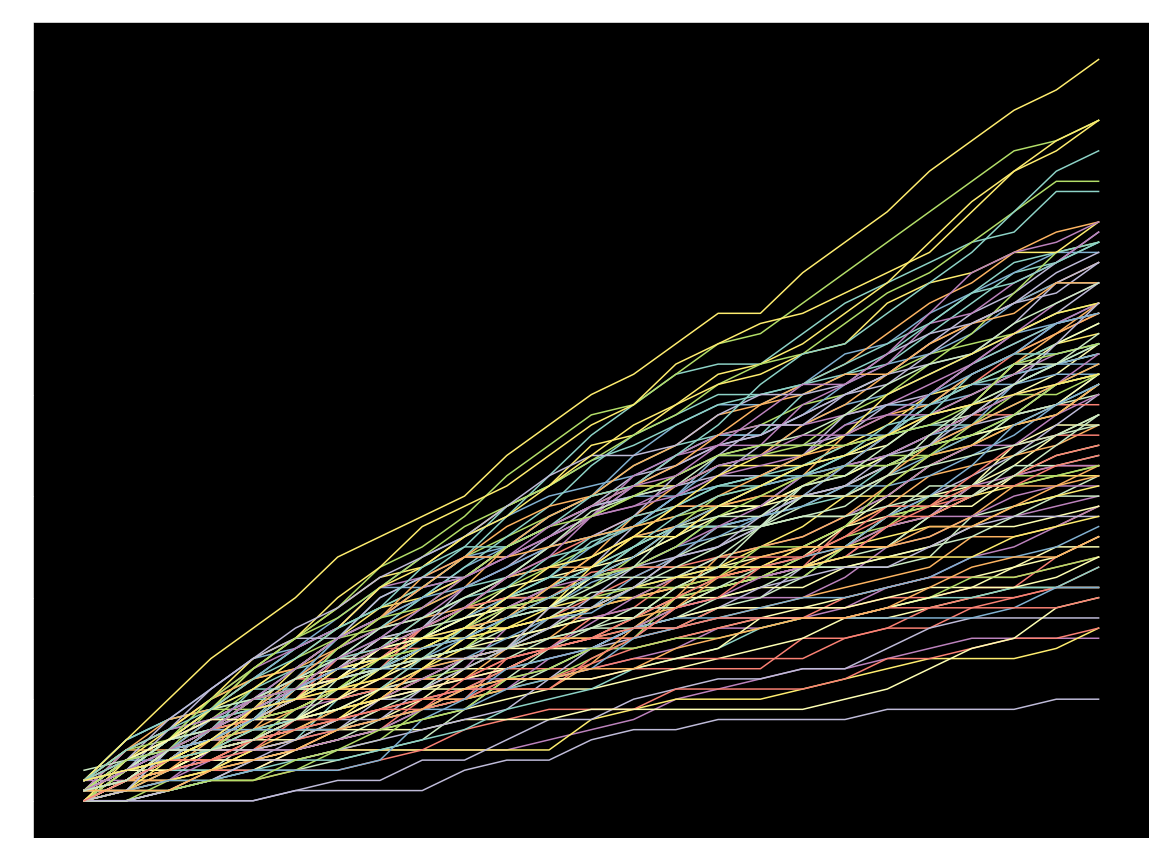

In [7]:
plt.figure(figsize=(20,15))
for i in range(0, len(values)):
    plt.plot(values.values[i])

plt.title('Wins - Defined by Median of Every 5 days')
plt.show()

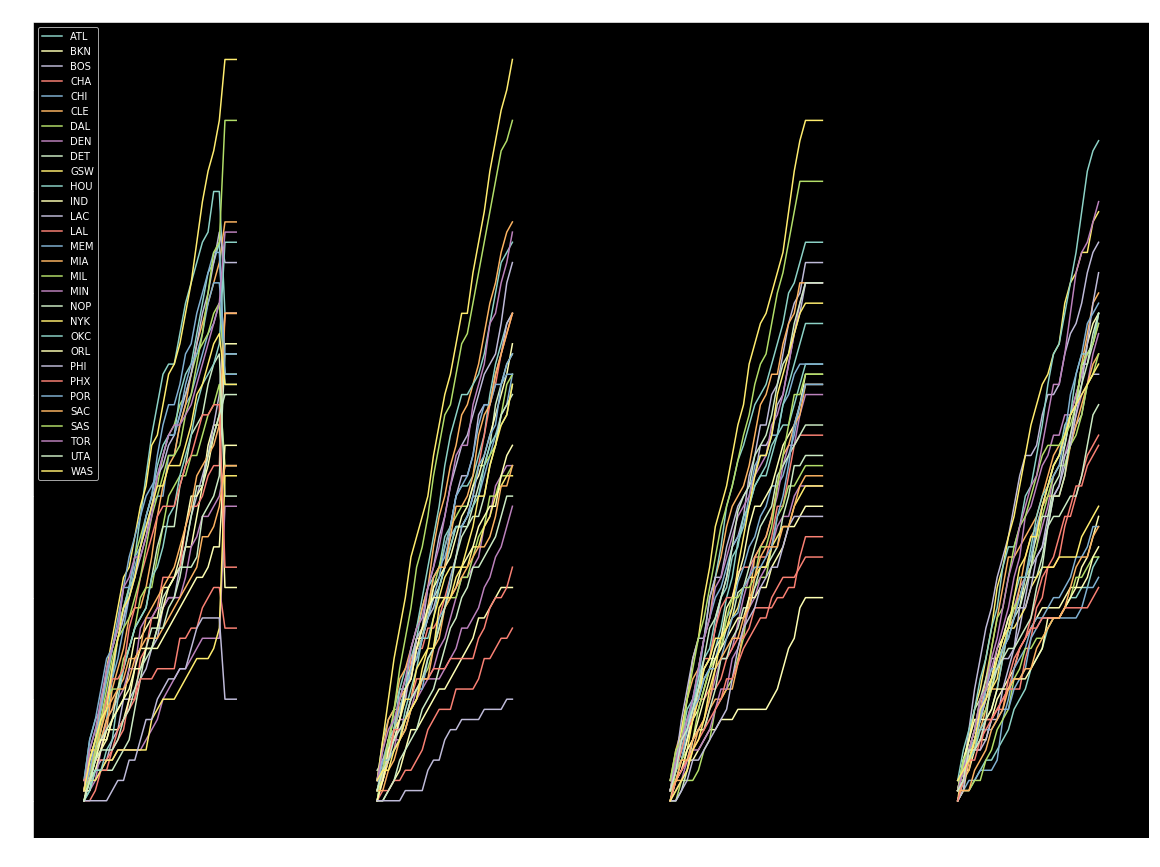

In [8]:
plt.figure(figsize=(20,15))
for i in range(0, len(values_loss)):

    plt.plot(values_win.values[i], label=values_win.index[i])

plt.legend()
plt.title('Losses - Defined by Median of Every 5 days')
plt.show()

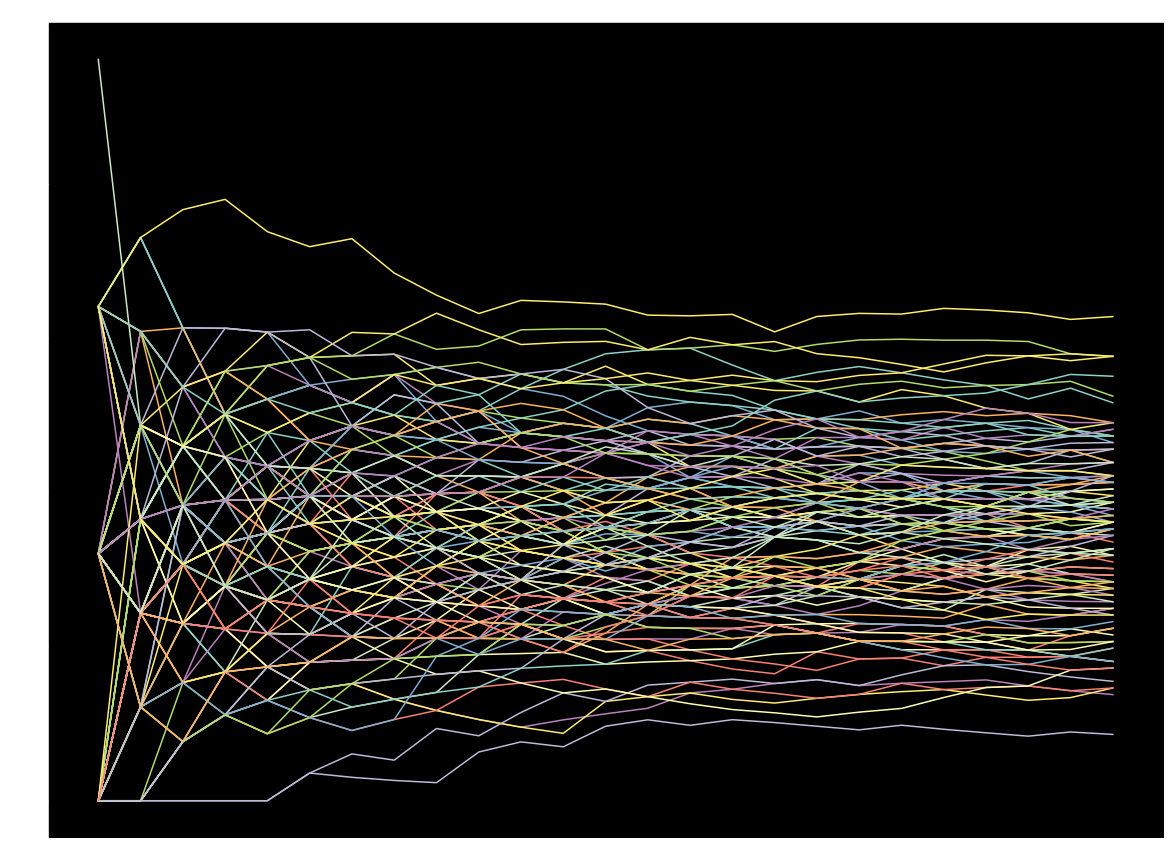

In [9]:
plt.figure(figsize=(20,15))
for i in range(0, len(values)):
    plt.plot(x_norm2.values[i], label=x_norm2.index[i])

plt.title('Wins Normalized')
plt.show()

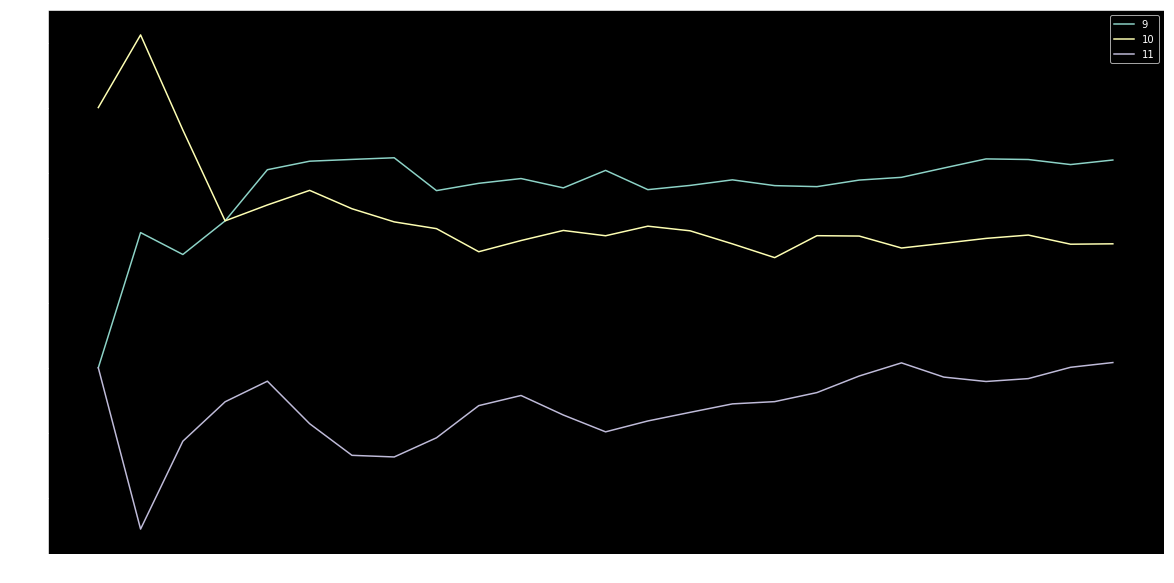

In [10]:
plt.figure(figsize=(20,10))
for i in range(9, 12):
    plt.plot(x_norm2.values[i], label=values.index[i])
plt.legend()
plt.show()

In [11]:
X_train, X_test = train_test_split(x_norm2, test_size=0.05)

In [12]:
X_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
4,0.080064,0.152075,0.134071,0.111348,0.108465,0.107720,0.106235,0.111799,0.117021,0.121031,0.119213,0.117946,0.116661,0.112393,0.104749,0.111624,0.107623,0.111653,0.111977,0.108754,0.108072,0.107638,0.106948,0.104715,0.105307
65,0.160128,0.152075,0.134071,0.139185,0.130158,0.116696,0.121411,0.118375,0.128723,0.126293,0.128750,0.126682,0.120684,0.116140,0.115224,0.118190,0.123450,0.120706,0.120591,0.114192,0.115791,0.114977,0.111597,0.113627,0.109606
78,0.000000,0.000000,0.019153,0.041755,0.065079,0.062837,0.053117,0.059187,0.064362,0.073671,0.066759,0.069894,0.068387,0.071183,0.066341,0.068944,0.072804,0.069406,0.068909,0.067971,0.072048,0.073390,0.076723,0.073523,0.073070
116,0.080064,0.121660,0.095765,0.097429,0.108465,0.098743,0.113823,0.118375,0.111170,0.115769,0.119213,0.117946,0.112638,0.112393,0.111732,0.111624,0.110788,0.105618,0.100493,0.097879,0.095206,0.095406,0.099973,0.098031,0.096711
71,0.080064,0.060830,0.076612,0.083511,0.086772,0.080790,0.083470,0.085493,0.087766,0.084195,0.090602,0.087367,0.088501,0.089915,0.094274,0.095208,0.091796,0.090530,0.089008,0.089722,0.090060,0.088067,0.086023,0.086891,0.090264
54,0.080064,0.121660,0.076612,0.069592,0.065079,0.071813,0.075882,0.072340,0.064362,0.073671,0.071528,0.078630,0.076433,0.082422,0.083799,0.088642,0.088631,0.090530,0.094750,0.092441,0.092633,0.090514,0.095323,0.095803,0.094562


In [13]:
len(X_train)

114

In [87]:
%timeit
# maybe try quantile : https://scikit-garden.github.io/examples/QuantileRegressionForests/
def split_time_series(X_tr, X_te, proportion=0.6):
    len_ts = X_tr.shape[1]
    len_input = int(proportion)
    len_output = len_ts - len_input

    return np.float32(X_tr[:, :len_input]), \
           np.float32(X_tr[:, len_input:]), \
           np.float32(X_te[:, :len_input]), \
           np.float32(X_te[:, len_input:])


class MLP(Chain):
    def __init__(self, len_input, len_output, activation="tanh", n_units=50):
        self.activation = activation

        super(MLP, self).__init__(
            mid = L.Linear(len_input, n_units),
            out=L.Linear(n_units, len_output),
        )

    def __call__(self, x):
        # Given the current observation, predict the rest.
        xx = self.mid(x)
        func = getattr(F, self.activation)
        h = func(xx)
        y = self.out(h)
        return y


class Objective(Chain):
    def __init__(self, predictor, loss="euclidean", gamma=1.0):
        self.loss = loss
        self.gamma = gamma
        super(Objective, self).__init__(predictor=predictor)

    def __call__(self, x, t):
        y = self.predictor(x)

        if self.loss == "euclidean":
            return F.mean_squared_error(y, t)

        elif self.loss == "sdtw":
            loss = 0
            for i in range(y.shape[0]):
                y_i = F.reshape(y[i], (-1,1))
                t_i = F.reshape(t[i], (-1,1))
                loss += SoftDTWLoss(self.gamma)(y_i, t_i)
            return loss

        else:
            raise ValueError("Unknown loss")


def train(network, loss, X_tr, Y_tr, X_te, Y_te, n_epochs=30, gamma=1):
    model= Objective(network, loss=loss, gamma=gamma)

    # optimizer = optimizers.SGD()
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    train = tuple_dataset.TupleDataset(X_tr, Y_tr)
    test = tuple_dataset.TupleDataset(X_te, Y_te)

    train_iter = iterators.SerialIterator(train, batch_size=1, shuffle=True)
    test_iter = iterators.SerialIterator(test, batch_size=1, repeat=False,
                                         shuffle=False)
    updater = training.StandardUpdater(train_iter, optimizer)
    trainer = training.Trainer(updater, (n_epochs, 'epoch'))

    trainer.run()


proportion = 10
n_units = 5
n_epochs = 50
gamma = 0.9
warm_start = True
X_tr = X_train.values
X_te = X_test.values

X_te_ = X_test.values
X_tr, Y_tr, X_te, Y_te = split_time_series(X_tr, X_te, proportion)

len_input = X_tr.shape[1]
len_output = Y_tr.shape[1]

networks = [MLP(len_input, len_output, n_units=n_units),]
losses = ["sdtw",]
labels = ["Soft-DTW loss",]

for i in range(len(networks)):
    if warm_start and i >= 1:
        # Warm-start with Euclidean-case solution
        networks[i].mid = copy.deepcopy(networks[0].mid)
        networks[i].out = copy.deepcopy(networks[0].out)

    train(networks[i], losses[i], X_tr, Y_tr, X_te, Y_te, n_epochs=n_epochs, gamma=gamma)

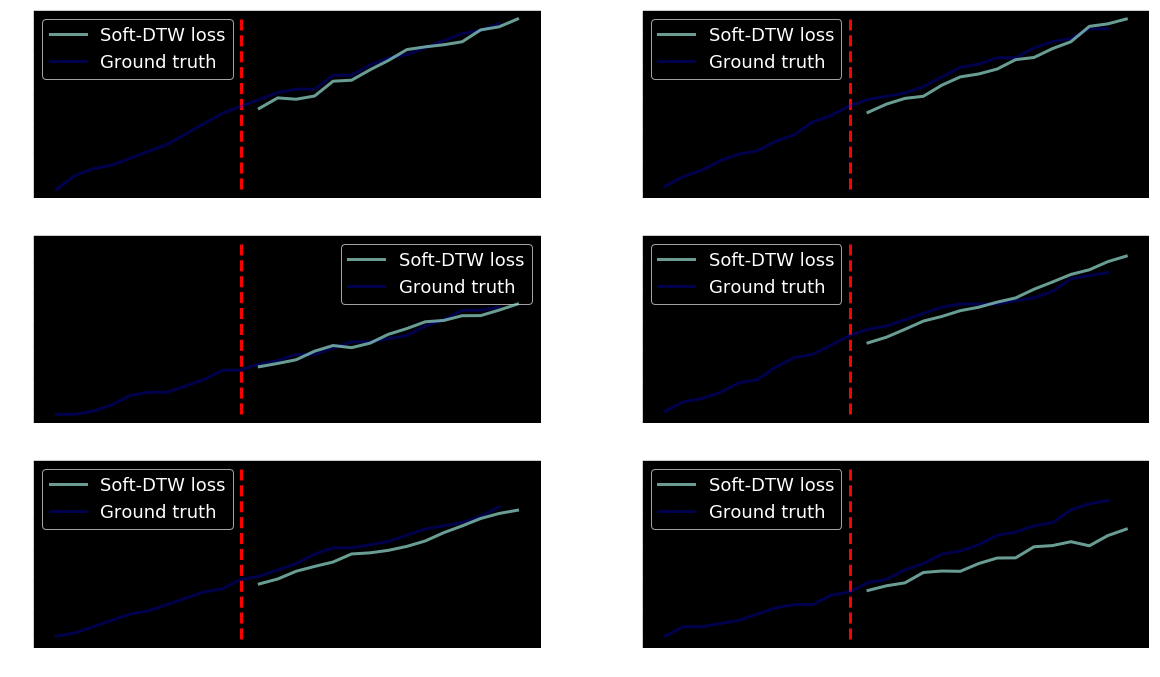

In [88]:
max_vals = []
min_vals = []

fig = plt.figure(figsize=(20,20))

pos = 520

len_ts = len(w)
len_input=int(proportion)
len_output=len_ts - len_input
len(w[len_input:len_output+len_input])

for i in range(min(X_te.shape[0], 9)):
    pos += 1
    ax = fig.add_subplot(pos)

    inputseq = np.array([X_te[i]])  # Need to wrap as minibatch...

    # Plot predictions.
    for idx, label in enumerate(labels):
        output = networks[idx](inputseq) * w[len_input:len_output+len_input]
        output = np.squeeze(np.array(output.data))

        ax.plot(range(len_input + 1,len_input + len(output) + 1),
                 output,
                 alpha=0.75,
                 lw=3,
                 label=label,
                 zorder=10)

        max_vals.append(output.max())
        min_vals.append(output.min())

    # Plot ground-truth time series.
    ground_truth = X_te_[i] * w
    max_vals.append(ground_truth.max())
    min_vals.append(ground_truth.min())
    ax.plot(ground_truth,
             c="b",
             alpha=0.3,
             lw=3,
             label='Ground truth',
             zorder=5)

    # Plot vertical line.
    ax.plot([len_input, len_input],
             [np.min(min_vals), np.max(max_vals)], lw=3, ls="--", c="r")

    # Legend.
    prop = fm.FontProperties(size=18)
    ax.legend(loc="best", prop=prop)

plt.show()

[-0.57  0.46 -1.92 -1.98  2.3  -1.43  1.58  1.29  2.44  2.23  0.83 -0.3
  1.13  1.02  1.28]
[-2.03 -1.45 -0.67 -1.01  0.44  0.02 -2.07 -1.53 -0.61  0.07 -0.17 -0.03
  3.76  1.53  3.05]
[ 1.11  0.14  0.32  1.04  2.83  0.15 -0.43  2.39  3.21  4.36  1.78  1.27
 -1.68  0.06  0.98]
[-2.32 -2.53 -1.03 -0.43 -0.96 -1.12 -1.03  0.59  1.91  3.68  4.98  5.37
  2.85  4.42  5.19]
[-1.45 -0.88 -0.42 -0.89 -2.5  -1.95 -1.59 -1.79 -1.54 -1.82 -1.19 -0.04
  1.3   0.9  -1.06]
[  0.49  -1.04  -1.11  -0.82  -2.35  -5.44  -3.98  -4.23  -7.18  -4.66
  -6.28  -6.05 -11.35 -10.11  -9.06]


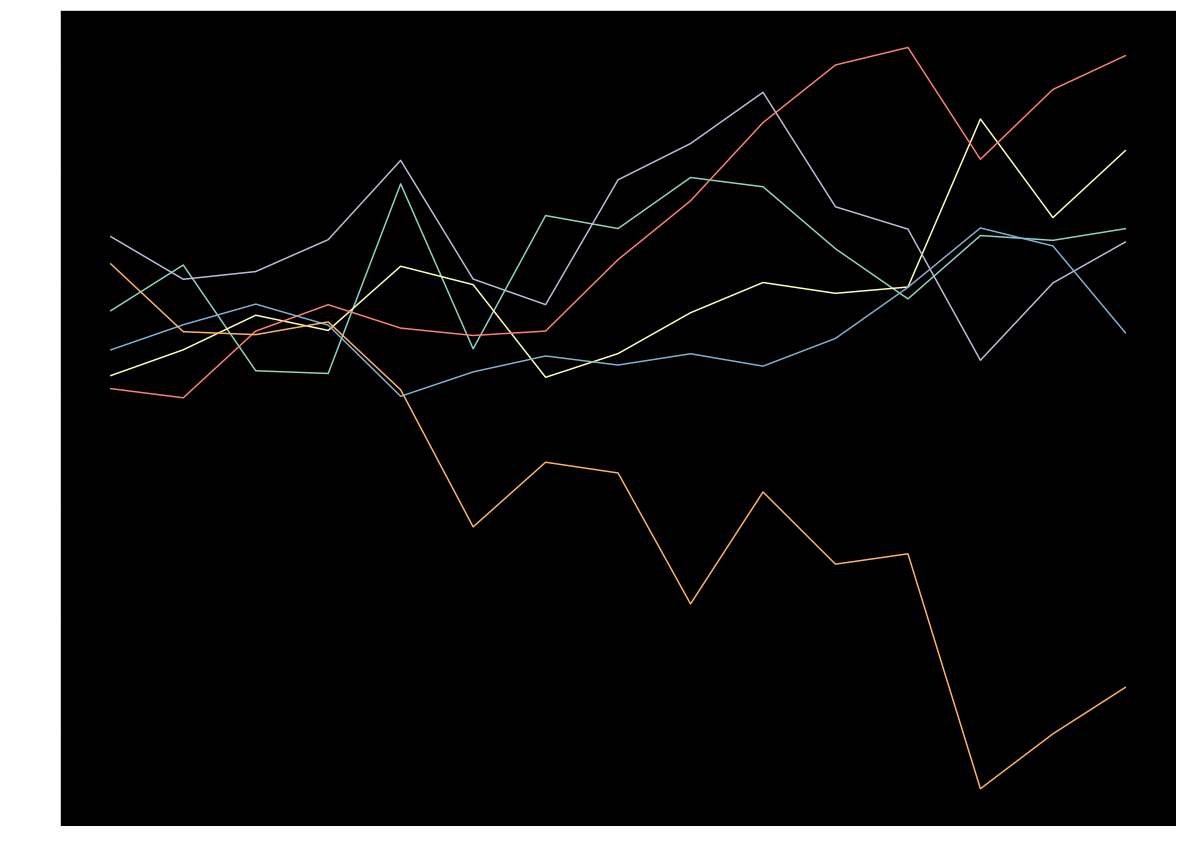

In [89]:
plt.figure(figsize=(20,15))
error_list = []
predictions= []
actuals = []
for i in range(X_te.shape[0]):
    error = networks[0](np.array([X_te[i]]))[0] * w[len_input:len_output+len_input] - Y_te[i] *  w[len_input:len_output+len_input]
    prediction = networks[0](np.array([X_te[i]]))[0] * w[len_input:len_output+len_input]
    actual = Y_te[i] *  w[len_input:len_output+len_input]
    actuals.append(actual.data[-1])
    predictions.append(prediction.data[-1])
    print(np.round(error.data, 2))
    plt.plot(error.data)
    error_list.append(np.median(error.data))
    
plt.show()

In [17]:
np.median(error_list)

-0.17617035

In [18]:
error_list

[1.6044235, -0.18314743, -3.5527, -0.16919327, -2.259697, 4.7373505]

In [19]:
predictions_df = pd.DataFrame({'predictions': predictions, 'actual': actuals})

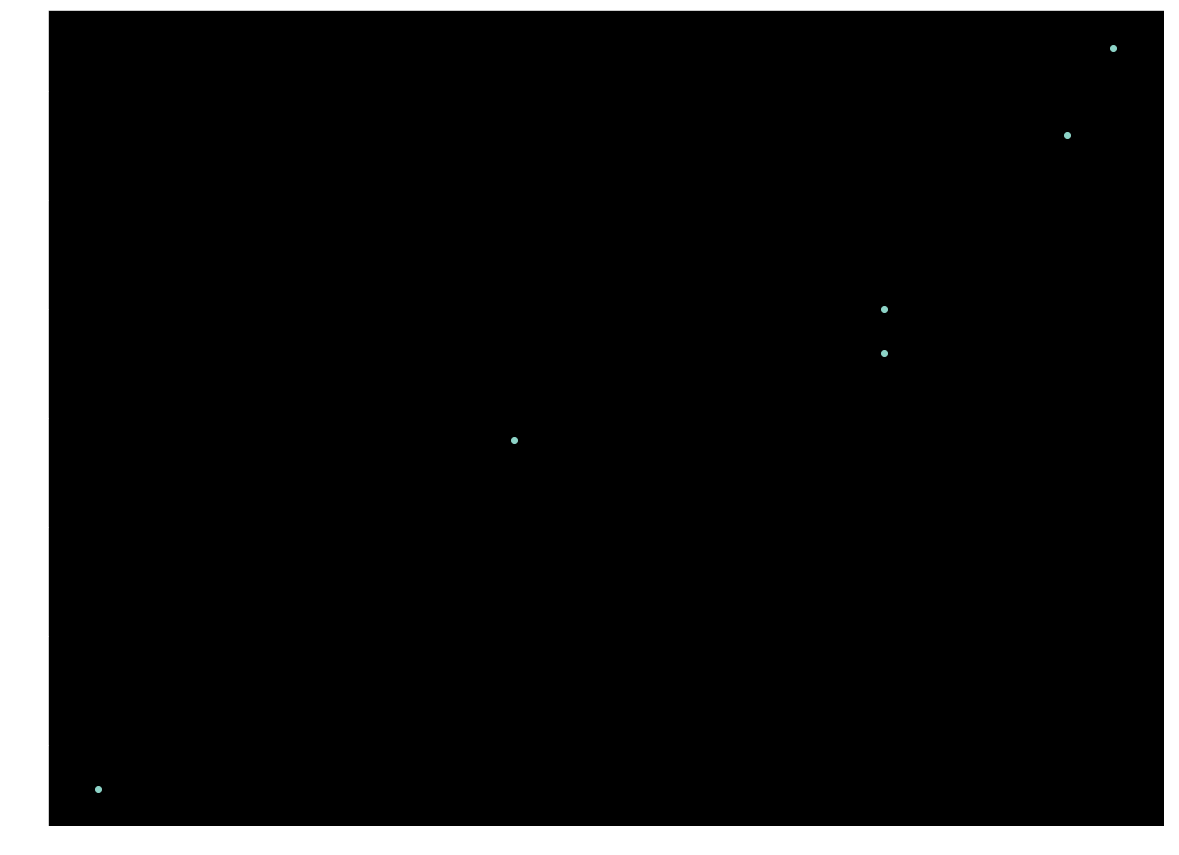

In [20]:
plt.figure(figsize=(20,15))

plt.scatter(predictions_df['predictions'], predictions_df['actual'])
plt.show()

In [21]:
predictions_df

,predictions,actual
0,52.516960,49.000000
1,53.707439,51.000000
2,27.256268,33.999999
3,47.739304,45.000001
4,38.105991,42.000000
5,47.739304,44.000000


In [22]:
def get_predictions(networks, w, len_output, len_input, new_season_wins):
    new_season_predict = []
    for i in range(0, len(new_season_wins)):
        predictions = networks[0](np.array([
            (new_season_wins.iloc[i].values / w[:len_input]).astype('float32')
        ]))[0] * w[len_input:len_output+len_input]

        final_predictions = predictions.data[-1]
        predict_array = [new_season_wins.iloc[i].name, final_predictions]
        new_season_predict.append(predict_array)
        print(predict_array)
    return new_season_predict

In [23]:
new_season_predict = get_predictions(networks, w, len_output, len_input, new_season_wins)

['ATL', 34.493668]
['BKN', 35.691154]
['BOS', 38.10599]
['CHA', 38.10599]
['CHI', 29.670086]
['CLE', 27.256268]
['DAL', 36.90006]
['DEN', 47.739304]
['DET', 42.93122]
['GSW', 46.484745]
['HOU', 32.08312]
['IND', 40.519913]
['LAC', 38.10599]
['LAL', 29.670086]
['MEM', 38.10599]
['MIA', 35.691154]
['MIL', 46.484745]
['MIN', 38.10599]
['NOP', 44.07284]
['NYK', 33.277096]
['OKC', 27.256268]
['ORL', 38.10599]
['PHI', 38.10599]
['PHX', 33.277096]
['POR', 38.10599]
['SAC', 34.493668]
['SAS', 38.10599]
['TOR', 51.30373]
['UTA', 35.691154]
['WAS', 32.08312]


In [24]:
new_season_predict_df = pd.DataFrame(new_season_predict).sort_values(1)
new_season_predict_df

,0,1
20,OKC,27.256268
5,CLE,27.256268
4,CHI,29.670086
13,LAL,29.670086
29,WAS,32.083118
10,HOU,32.083118
23,PHX,33.277096
19,NYK,33.277096
25,SAC,34.493668
0,ATL,34.493668


In [25]:
PLAYERS = {0: 'Chris',
           1: 'Luke',
           2: 'Dennis',
           3: 'Noe',
           4: 'Marc',
           5: 'Ryne',
           6: 'Dom',
           7: 'Jason',
           8: 'Nick',
           9: 'Luis'
           }
TEAMS = {'TOR': 0, 'PHX': 0, 'IND': 0,
         'GSW': 1, 'DET': 1, 'ORL': 1,
         'BOS': 2, 'CHA': 2, 'SAC': 2,
         'NOP': 3, 'PHI': 3, 'CLE': 3,
         'MEM': 4, 'MIL': 4, 'ATL': 4,
         'HOU': 5, 'MIA': 5, 'NYK': 5,
         'UTA': 6, 'DEN': 6, 'CHI': 6,
         'LAL': 7, 'MIN': 7, 'BKN': 7,
         'SAS': 8, 'POR': 8, 'LAC': 8,
         'OKC': 9, 'WAS': 9, 'DAL': 9
         }
new_season_predict_df.columns =  ['team', 'wins']

new_season_predict_df['user'] = new_season_predict_df['team'].map(TEAMS).map(PLAYERS)

new_season_predict_df.groupby('user')['wins'].sum().astype(int)

user
Chris     125
Dennis    110
Dom       113
Jason     103
Luis       96
Luke      127
Marc      119
Nick      114
Noe       109
Ryne      101
Name: wins, dtype: int64

In [26]:
train_y = []
for y in Y_tr:
    train_y.append(y[-1])

In [42]:
from skgarden import RandomForestQuantileRegressor
rfqr = RandomForestQuantileRegressor(random_state=0,  min_samples_split=2, n_estimators=100, criterion='mae')
rfqr.fit(X_tr, train_y)
y_mean = rfqr.predict(new_season_wins.iloc[:,0:2].values)
y_high = rfqr.predict(new_season_wins.iloc[:,0:2].values, 60)
y_low= rfqr.predict(new_season_wins.iloc[:,0:2].values, 20)

In [97]:
y_mean * w[-1]

array([52.56999974, 54.66999967, 38.17000009, 53.26000032, 41.65500012,
       37.74000017])

In [98]:
y_high * w[-1]

array([54.99999857, 54.99999857, 40.00000054, 56.00000006, 45.00000104,
       40.00000054])

In [99]:
y_low * w[-1]

array([49.00000005, 49.00000005, 29.66666592, 49.51314375, 36.99999954,
       33.00000053])

In [46]:
new_season_wins['high'] = y_high * w[-1]
new_season_wins['low'] = y_low * w[-1]
new_season_wins['point'] = y_mean * w[-1]
new_season_wins['team']= new_season_wins.index
new_season_wins['user'] = new_season_wins['team'].map(TEAMS).map(PLAYERS)

new_season_wins.groupby('user')['high'].sum().astype(int).sort_values(ascending=False)

user
Nick      164
Luke      164
Chris     164
Ryne      158
Marc      158
Jason     158
Dom       158
Dennis    158
Noe       137
Luis      126
Name: high, dtype: int64

In [32]:
new_season_wins.groupby('user')['low'].sum().astype(int).sort_values(ascending=False)

user
Nick      143
Luke      143
Chris     143
Ryne      126
Marc      126
Jason     126
Dom       126
Dennis    126
Noe       113
Luis       78
Name: low, dtype: int64

In [33]:
new_season_wins.groupby('user')['point'].sum().astype(int).sort_values(ascending=False)

user
Nick      166
Luke      166
Chris     166
Ryne      157
Marc      157
Jason     157
Dom       157
Dennis    157
Noe       134
Luis      116
Name: point, dtype: int64

In [47]:
new_season_wins

win                           high        low  \
timestamp   2018-10-16 00:00:00 2018-10-23 00:00:00                         
team_abbrev                                                                 
ATL                         0.0                 1.5  49.000000  31.138260   
BKN                         1.0                 1.5  54.919566  48.181844   
BOS                         1.0                 2.0  54.919566  48.181844   
CHA                         1.0                 2.0  54.919566  48.181844   
CHI                         0.0                 0.5  49.000000  31.138260   
CLE                         0.0                 0.0  28.000000  17.850750   
DAL                         0.0                 2.0  49.000000  31.138260   
DEN                         1.0                 4.0  54.919566  48.181844   
DET                         1.0                 3.0  54.919566  48.181844   
GSW                         2.0                 3.5  54.919566  48.181844   
HOU                         0.0                 1.0  49.000000  31.138260   
IND                         1.0                 2.5  54.919566  48.181844   
LAC                         1.0                 2.0  54.919566  48.181844   
LAL                         0.0                 0.5  49.000000  31.138260   
MEM                         1.0                 2.0  54.919566  48.181844   
MIA                         1.0                 1.5  54.919566  48.181844   
MIL                         2.0                 3.5  54.919566  48.181844   
MIN                         1.0                 2.0  54.919566  48.181844   
NOP                         2.0                 3.0  54.919566  48.181844   
NYK                         1.0                 1.0  54.919566  48.181844   
OKC                         0.0                 0.0  28.000000  17.850750   
ORL                         1.0                 2.0  54.919566  48.181844   
PHI                         1.0                 2.0  54.919566  48.181844   
PHX                         1.0                 1.0  54.919566  48.181844   
POR                         1.0                 2.0  54.919566  48.181844   
SAC                         0.0                 1.5  49.000000  31.138260   
SAS                         1.0                 2.0  54.919566  48.181844   
TOR                         2.0                 4.5  54.919566  48.181844   
UTA                         1.0                 1.5  54.919566  48.181844   
WAS                         0.0                 1.0  49.000000  31.138260   

                 point team    user  
timestamp                            
team_abbrev                          
ATL          46.155000  ATL    Marc  
BKN          54.999999  BKN   Jason  
BOS          54.999999  BOS  Dennis  
CHA          54.999999  CHA  Dennis  
CHI          46.155000  CHI     Dom  
CLE          23.425000  CLE     Noe  
DAL          46.155000  DAL    Luis  
DEN          54.999999  DEN     Dom  
DET          54.999999  DET    Luke  
GSW          54.999999  GSW    Luke  
HOU          46.155000  HOU    Ryne  
IND          54.999999  IND   Chris  
LAC          54.999999  LAC    Nick  
LAL          46.155000  LAL   Jason  
MEM          54.999999  MEM    Marc  
MIA          54.999999  MIA    Ryne  
MIL          54.999999  MIL    Marc  
MIN          54.999999  MIN   Jason  
NOP          54.999999  NOP     Noe  
NYK          54.999999  NYK    Ryne  
OKC          23.425000  OKC    Luis  
ORL          54.999999  ORL    Luke  
PHI          54.999999  PHI     Noe  
PHX          54.999999  PHX   Chris  
POR          54.999999  POR    Nick  
SAC          46.155000  SAC  Dennis  
SAS          54.999999  SAS    Nick  
TOR          54.999999  TOR   Chris  
UTA          54.999999  UTA     Dom  
WAS          46.155000  WAS    Luis

In [51]:
all_predictions  = new_season_predict_df.merge(new_season_wins, on='team')

In [57]:
all_predictions.columns = ['team', 'wins', 'user', 'win0', 'win1', 'high', 'low', 'point', 'user2']

In [63]:
agg_all_predictions = all_predictions[['user', 'wins', 'high', 'low','point']].groupby('user').sum().astype(int)
agg_all_predictions['id'] = np.arange(0, len(agg_all_predictions))

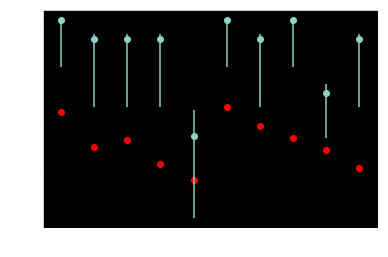

In [84]:
plt.errorbar(agg_all_predictions['id'], agg_all_predictions['point'], yerr=[agg_all_predictions['point']- agg_all_predictions['low'],
                                                                            agg_all_predictions['high']- agg_all_predictions['point']], fmt='o')
plt.scatter(agg_all_predictions['id'], agg_all_predictions['wins'], c='r')
plt.show()


In [70]:
agg_all_predictions

,wins,high,low,point,id
user,,,,,
Chris,125,164,144,164,0
Dennis,110,158,127,156,1
Dom,113,158,127,156,2
Jason,103,158,127,156,3
Luis,96,126,80,115,4
Luke,127,164,144,164,5
Marc,119,158,127,156,6
Nick,114,164,144,164,7
Noe,109,137,114,133,8


In [115]:
test_y = []
for y in Y_te:
    test_y.append(np.float(y[-1]))


y_mean_test = rfqr.predict(X_te)
y_high_test = rfqr.predict(X_te, 60)
y_low_test = rfqr.predict(X_te, 20)

test_predictions = pd.DataFrame({'high': y_high_test * w[-1], 'low':y_low_test * w[-1], 'point': y_mean_test * w[-1], 'actual':np.array(test_y) * w[-1], 'nn':predictions})
test_predictions['id'] = np.arange(0, len(test_predictions))
test_predictions


,high,low,point,actual,nn,id
0,54.999999,49.000000,52.570,49.000000,50.284386,0
1,54.999999,49.000000,54.670,51.000000,54.045715,1
2,40.000001,29.666666,38.170,33.999999,34.983738,2
3,56.000000,49.513144,53.260,45.000001,50.187767,3
4,45.000001,37.000000,41.655,42.000000,40.937611,4
5,40.000001,33.000001,37.740,44.000000,34.936310,5


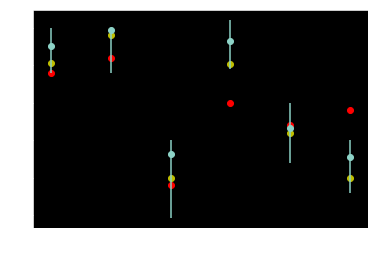

In [118]:
plt.errorbar(test_predictions['id'], test_predictions['point'], yerr=[test_predictions['point']- test_predictions['low'],
                                                                            test_predictions['high']- test_predictions['point']], fmt='o')
plt.scatter(test_predictions['id'], test_predictions['actual'], c='r')
plt.scatter(test_predictions['id'], test_predictions['nn'], c='y')

plt.show()
